# Battery Analysis on All Batteries

Performs a quick analysis across all the batteries

In [27]:
# Import important libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import seaborn as sns   # For plotting
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
from scipy import io
from datetime import datetime

# Supress SettingWithCopyWarning
import warnings
warnings.filterwarnings('ignore')


In [2]:
def get_battery_data(folder_path, query, idx):

    df = pd.DataFrame()
    # Iterate through all files in the folder
    for file in os.listdir(folder_path):
        
        battery_path = os.path.join(folder_path, file)
        mat = io.loadmat(battery_path, simplify_cells=True)

        temp_df = pd.DataFrame(mat['data']['step'])
        battery = file.split('.')[0]
        temp_df['battery'] = battery
        temp_df['battery_set'] = idx
        temp_df = temp_df.query('type in @query')
        temp_df = create_features(temp_df)
        df = pd.concat([df, temp_df])
        print(f'Loaded {battery}')

    return df

In [19]:
def create_features(unprocessed_df: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes an unprocessed DataFrame and returns a processed DataFrame with additional features.
    
    Args:
        unprocessed_df (pd.DataFrame): The unprocessed DataFrame to be processed.
    
    Returns:
        pd.DataFrame: The processed DataFrame with additional features.
    """
    
    format_string = "%d-%b-%Y %H:%M:%S"

    # Extract reference discharge data and compute capacity
    df_ref = unprocessed_df.query('comment=="reference discharge"')
    df_ref['df_ref '] = pd.to_datetime(df_ref['date'], format=format_string)
    df_ref['capacity (Ah)'] = 0.0
    df_ref['capacity (Ah)'] = [np.trapz(i, t) / 3600 for i, t in zip(df_ref['current'], df_ref['relativeTime'])] # compute the capacity in Ah
    df_ref['gt'] = True

    # Process unprocessed_df
    unprocessed_df['dateTime'] = pd.to_datetime(unprocessed_df['date'], format=format_string, errors='coerce')
    unprocessed_df['date'] = unprocessed_df['dateTime'].apply(lambda x: x.date()) 
    unprocessed_df['time'] = unprocessed_df['time'].apply(lambda x: x if isinstance(x, np.ndarray) else np.array([x]))
    unprocessed_df['voltage'] = unprocessed_df['voltage'].apply(lambda x: x if isinstance(x, np.ndarray) else np.array([x]))
    unprocessed_df['current'] = unprocessed_df['current'].apply(lambda x: x if isinstance(x, np.ndarray) else np.array([x]))
    unprocessed_df['timeRange'] = unprocessed_df['relativeTime'].apply(lambda x: x[-1] if isinstance(x, np.ndarray) else x)
    
    unprocessed_df['avgTemperature'] = unprocessed_df['temperature'].apply(lambda x: np.mean(x))
    unprocessed_df['varTemperatureCycle'] = unprocessed_df['temperature'].apply(lambda x: np.var(x))
    unprocessed_df['maxTemperatureCycle'] = unprocessed_df['temperature'].apply(lambda x: np.max(x))
    unprocessed_df['minTemperatureCycle'] = unprocessed_df['temperature'].apply(lambda x: np.min(x))
    unprocessed_df['kurtosisTemperatureCycle'] = unprocessed_df['temperature'].apply(lambda x: pd.Series(x).kurtosis())
    unprocessed_df['skewnessTemperatureCycle'] = unprocessed_df['temperature'].apply(lambda x: pd.Series(x).skew())
    
    unprocessed_df['avgCurrent'] = unprocessed_df['current'].apply(lambda x: np.mean(x))
    unprocessed_df['varCurrent'] = unprocessed_df['current'].apply(lambda x: np.var(x))
    unprocessed_df['maxCurrent'] = unprocessed_df['current'].apply(lambda x: np.max(x))
    unprocessed_df['minCurrent'] = unprocessed_df['current'].apply(lambda x: np.min(x))
    unprocessed_df['kurtosisCurrent'] = unprocessed_df['current'].apply(lambda x: pd.Series(x).kurtosis())
    unprocessed_df['skewnessCurrent'] = unprocessed_df['current'].apply(lambda x: pd.Series(x).skew())

    unprocessed_df['avgVoltage'] = unprocessed_df['voltage'].apply(lambda x: np.mean(x))
    unprocessed_df['varVoltage'] = unprocessed_df['voltage'].apply(lambda x: np.var(x))
    unprocessed_df['maxVoltage'] = unprocessed_df['voltage'].apply(lambda x: np.max(x))
    unprocessed_df['minVoltage'] = unprocessed_df['voltage'].apply(lambda x: np.min(x))
    unprocessed_df['kurtosisVoltage'] = unprocessed_df['voltage'].apply(lambda x: pd.Series(x).kurtosis())
    unprocessed_df['skewnessVoltage'] = unprocessed_df['voltage'].apply(lambda x: pd.Series(x).skew())

    unprocessed_df['resistance'] = unprocessed_df['voltage'] / unprocessed_df['current']
    unprocessed_df['avgResistance'] = unprocessed_df['resistance'].apply(lambda x: np.mean(x))
    unprocessed_df['varResistance'] = unprocessed_df['resistance'].apply(lambda x: np.var(x))
    unprocessed_df['maxResistance'] = unprocessed_df['resistance'].apply(lambda x: np.max(x))
    unprocessed_df['minResistance'] = unprocessed_df['resistance'].apply(lambda x: np.min(x))
    unprocessed_df['kurtosisResistance'] = unprocessed_df['resistance'].apply(lambda x: pd.Series(x).kurtosis())
    unprocessed_df['skewnessResistance'] = unprocessed_df['resistance'].apply(lambda x: pd.Series(x).skew())

    unprocessed_df['startVoltage'] = unprocessed_df['voltage'].apply(lambda x: x[0])
    unprocessed_df['terminalVoltage'] = unprocessed_df['voltage'].apply(lambda x: x[-1])
    unprocessed_df['deltaVoltage'] = unprocessed_df['terminalVoltage'] - unprocessed_df['startVoltage']

    # Compute the incremental change of the voltage vector
    # If the length of the voltage vector is 1, then the voltageRate is 0, no change is assumed
    unprocessed_df['voltageRate'] = unprocessed_df['voltage'].apply(lambda x: np.diff(x) if len(x) > 1 else np.array([0]))
    unprocessed_df['avgVoltageRate'] = unprocessed_df['voltageRate'].apply(lambda x: np.mean(x))
    unprocessed_df['varVoltageRate'] = unprocessed_df['voltageRate'].apply(lambda x: np.var(x))
    unprocessed_df['maxVoltageRate'] = unprocessed_df['voltageRate'].apply(lambda x: np.max(x))
    unprocessed_df['minVoltageRate'] = unprocessed_df['voltageRate'].apply(lambda x: np.min(x))
    unprocessed_df['kurtosisVoltageRate'] = unprocessed_df['voltageRate'].apply(lambda x: pd.Series(x).kurtosis())
    unprocessed_df['skewnessVoltageRate'] = unprocessed_df['voltageRate'].apply(lambda x: pd.Series(x).skew())

    unprocessed_df['rateOfVoltageLEGACY'] = (unprocessed_df['deltaVoltage'] / unprocessed_df['timeRange']) / 3600 
    unprocessed_df = unprocessed_df.join(df_ref[['capacity (Ah)', 'gt']], how='left')
    unprocessed_df['gt'] = unprocessed_df['gt'].notna()
    unprocessed_df['endTime'] = unprocessed_df['time'].apply(lambda x: x[-1]) / 3600
    unprocessed_df['cycle'] = unprocessed_df.index

    # Compute SoH for each battery

    # Add an empty soh column to unprocessed_df
    unprocessed_df['soh'] = np.nan
    unprocessed_df['soh'] = unprocessed_df['capacity (Ah)'] / unprocessed_df['capacity (Ah)'].dropna().iloc[0] * 100 # Compute the SoH

    # Add daily average temperature
    mean_df = unprocessed_df.groupby(['date'])[['avgTemperature']].mean().reset_index()
    unprocessed_df = unprocessed_df.merge(mean_df, on=['date'], suffixes=('Cycle', 'Daily'))

    # Select relevant columns for processed DataFrame
    processed_df = unprocessed_df[[
            'comment',
            'type',
            'battery',
            'battery_set',
            'dateTime',
            'endTime',
            'timeRange',
            'avgTemperatureCycle',
            'avgTemperatureDaily',
            'varTemperatureCycle',
            'maxTemperatureCycle',
            'minTemperatureCycle',
            'kurtosisTemperatureCycle',
            'skewnessTemperatureCycle',
            'avgVoltage',
            'varVoltage',
            'maxVoltage',
            'minVoltage',
            'kurtosisVoltage',
            'skewnessVoltage',
            'avgCurrent',
            'varCurrent',
            'maxCurrent',
            'minCurrent',
            'kurtosisCurrent',
            'skewnessCurrent',
            'avgVoltageRate',
            'varVoltageRate',
            'maxVoltageRate',
            'minVoltageRate',
            'kurtosisVoltageRate',
            'skewnessVoltageRate',
            'avgResistance',
            'varResistance',
            'maxResistance',
            'minResistance',
            'kurtosisResistance',
            'skewnessResistance',
            'startVoltage',
            'terminalVoltage',
            'deltaVoltage',
            'rateOfVoltageLEGACY',
            'gt',
            'cycle',
            'capacity (Ah)',
            'soh',
            ]]
    
    return processed_df


In [23]:
FOLDER_PATHS = [
    'battery datasets/1_Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab',
    # 'battery datasets/2_Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab',
    # 'battery datasets/3_Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post/data/Matlab',
    # 'battery datasets/4_RW_Skewed_High_40C_DataSet_2Post/data/Matlab',
    # 'battery datasets/5_RW_Skewed_High_Room_Temp_DataSet_2Post/data/Matlab',
    # 'battery datasets/6_RW_Skewed_Low_40C_DataSet_2Post/data/Matlab',
    # 'battery datasets/7_RW_Skewed_Low_Room_Temp_DataSet_2Post/data/Matlab',
]

df = pd.DataFrame()
# Edit this to use tqdm instead
for idx, folder_path in tqdm(enumerate(FOLDER_PATHS)):
    print(f'Processing {folder_path}...')
    df_temp = get_battery_data(folder_path, query=['D'], idx=idx+1)
    df = pd.concat([df, df_temp], ignore_index=True)

df.to_csv('battery_data.csv', index=False)

0it [00:00, ?it/s]

Processing battery datasets/1_Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab...
Loaded RW10
Loaded RW11
Loaded RW12
Loaded RW9
Processing battery datasets/2_Battery_Uniform_Distribution_Discharge_Room_Temp_DataSet_2Post/data/Matlab...
Loaded RW3
Loaded RW4
Loaded RW5
Loaded RW6
Processing battery datasets/3_Battery_Uniform_Distribution_Variable_Charge_Room_Temp_DataSet_2Post/data/Matlab...


KeyboardInterrupt: 

In [246]:
# Read in the processed data from .csv file
df = pd.read_csv('processed_datasets/All_But_Last.csv')

# Output full text to a separate temp.txt file

# Get all the indices where the kurtosisCurrent is NaN
# Count nan values in each column
# 

df.query('battery_name=="RW3"').iloc[-1]
# Soft df.loc[idx] by the timeRange
# df.loc[idx].sort_values(by=['timeRange'], ascending=False)

comment                discharge (random walk)
type                                         D
battery_name                               RW3
dateTime                   2014-06-02 14:11:51
endTime                            3765.685544
timeRange                                 3.19
avgTemperatureCycle                -4094.09814
avgTemperatureDaily                -4094.09814
varTemperatureCycle                        0.0
avgVoltage                              3.2328
varVoltage                            0.002001
maxVoltage                                3.32
minVoltage                                 3.2
avgCurrent                                 4.0
varCurrent                            0.000001
maxCurrent                               4.002
minCurrent                               3.999
avgVoltageRate                           -0.03
varVoltageRate                        0.001302
maxVoltageRate                          -0.002
minVoltageRate                          -0.092
avgResistance

soh                    1.000000
timeRange              0.988501
capacity (Ah)          0.988500
rateOfVoltageLEGACY    0.966242
avgResistance          0.910185
avgVoltage             0.910085
endTime                0.896578
cycle                  0.781696
varVoltage             0.720067
varResistance          0.718052
kurtosisVoltage        0.638369
minVoltageRate         0.635840
skewnessVoltageRate    0.579358
maxVoltage             0.560294
kurtosisResistance     0.553689
deltaVoltage           0.548534
startVoltage           0.548486
kurtosisVoltageRate    0.499646
skewnessVoltage        0.317342
avgVoltageRate         0.313345
Name: soh, dtype: float64

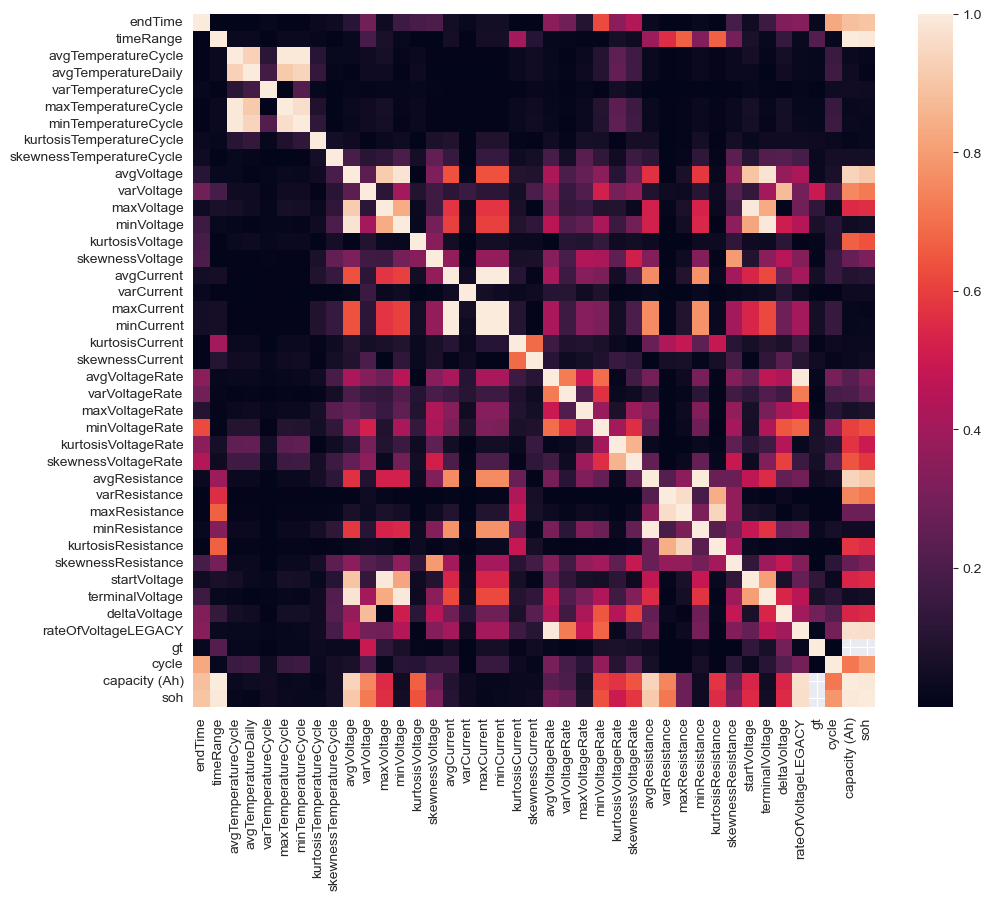

In [176]:
df.keys()

# Create a correlation matrix from the df
corr = df.corr()
# corr = df.corr()
# absolute value of the correlation matrix
corr = corr.abs() 

f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr)

# Get the top 10 features with the highest correlation with SoH
corr['soh'].sort_values(ascending=False).head(20)

soh                    1.000000
timeRange              0.988501
avgResistance          0.910185
avgVoltage             0.910085
endTime                0.896578
cycle                  0.781696
varVoltage             0.720067
varResistance          0.718052
kurtosisVoltage        0.638369
minVoltageRate         0.635840
skewnessVoltageRate    0.579358
maxVoltage             0.560294
kurtosisResistance     0.553689
deltaVoltage           0.548534
kurtosisVoltageRate    0.499646
Name: soh, dtype: float64

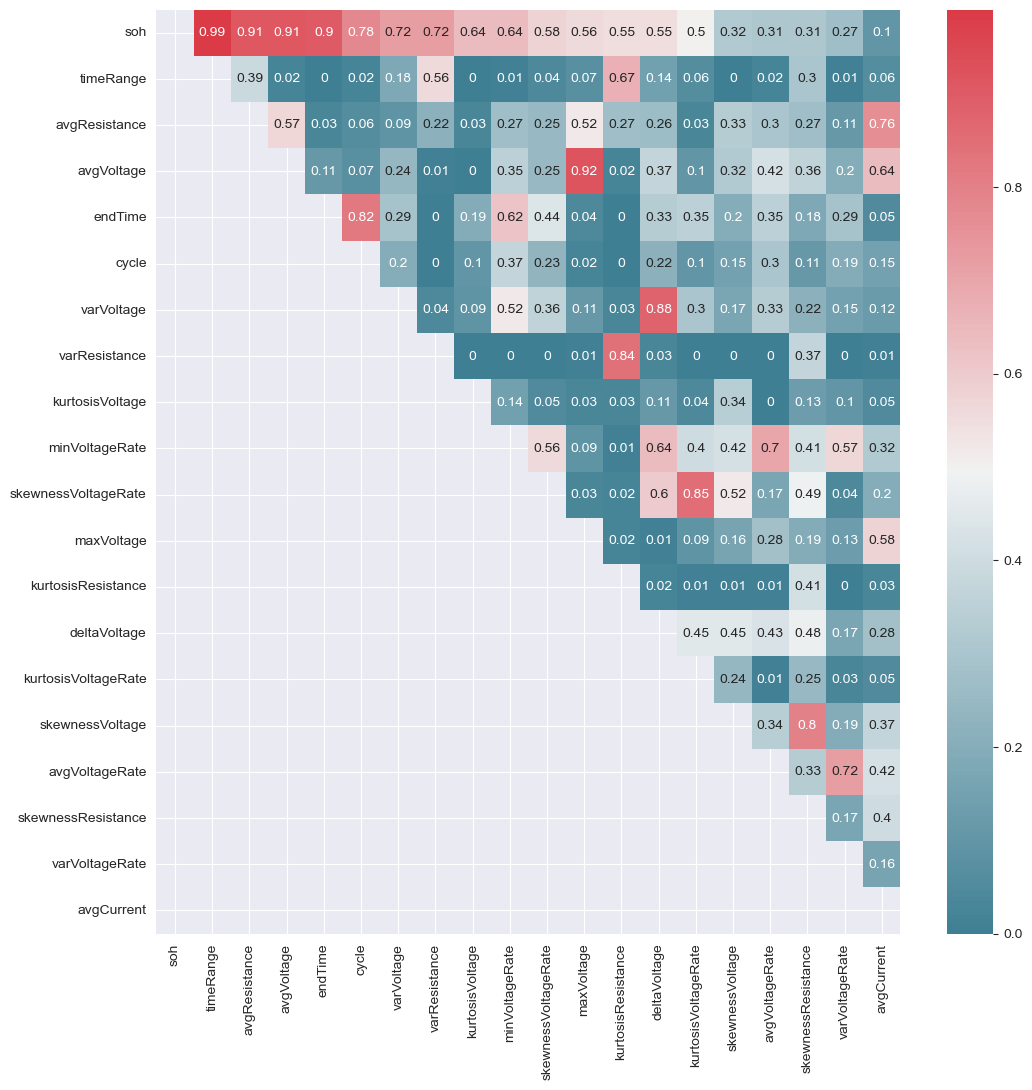

In [233]:
# Get the top 10 features with the highest correlation with SoH
top_features = corr['soh'].sort_values(ascending=False).head(20)
# Filter the correlation matrix to only include the top 10 features
corr = corr.loc[top_features.index, top_features.index]
# Remove the diagonal triangle from the correlation matrix
# corr = corr.mask(np.tril(np.ones(corr.shape)).astype(np.bool))
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
upper = upper.round(2)

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(upper, annot=True, cmap=cmap)

corr['soh'].sort_values(ascending=False).head(15)

soh                    1.000000
timeRange              0.988501
avgResistance          0.910185
avgVoltage             0.910085
endTime                0.896578
cycle                  0.781696
varVoltage             0.720067
varResistance          0.718052
kurtosisVoltage        0.638369
minVoltageRate         0.635840
skewnessVoltageRate    0.579358
maxVoltage             0.560294
kurtosisResistance     0.553689
deltaVoltage           0.548534
kurtosisVoltageRate    0.499646
skewnessVoltage        0.317342
avgVoltageRate         0.313345
skewnessResistance     0.313075
varVoltageRate         0.268419
avgCurrent             0.098602
Name: soh, dtype: float64


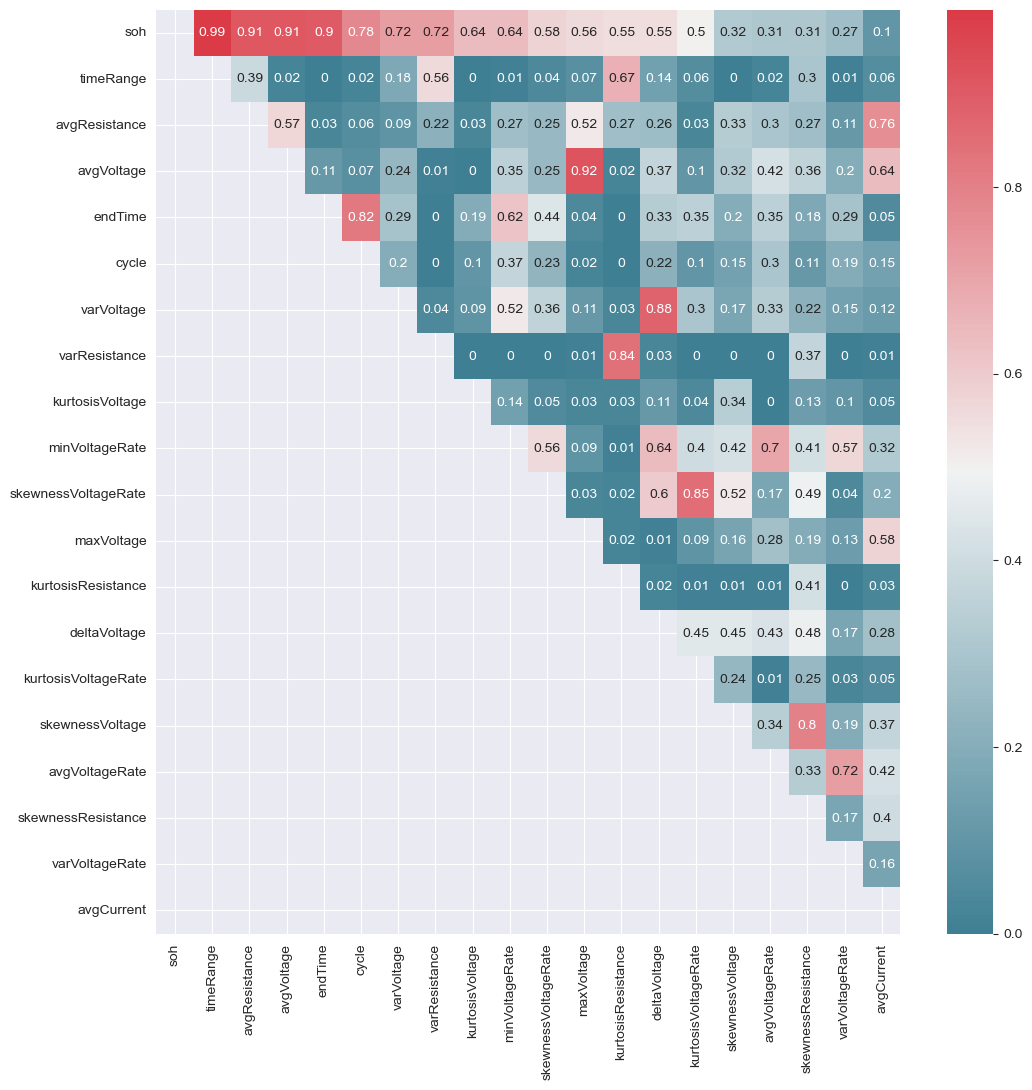

In [232]:
corr_matrix = df.drop(['soh'], axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Dropp aoh from both column and row
to_drop = [column for column in upper.columns if any(upper[column] > 0.95) and column != 'soh']
drop_df = df.drop(to_drop, axis=1)
corr = drop_df.corr()
corr = corr.abs()

# Get the top 10 features with the highest correlation with SoH
top_features = corr['soh'].sort_values(ascending=False).head(20)
corr = corr.loc[top_features.index, top_features.index]

# # Remove the diagonal triangle from the correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
upper = upper.round(2)
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(upper, annot=True, cmap=cmap)
print(top_features)

In [219]:
to_drop

['maxTemperatureCycle',
 'minTemperatureCycle',
 'minVoltage',
 'maxCurrent',
 'minCurrent',
 'maxResistance',
 'minResistance',
 'startVoltage',
 'terminalVoltage',
 'rateOfVoltageLEGACY',
 'capacity (Ah)']

In [ ]:
mat = io.loadmat('battery datasets/1_Battery_Uniform_Distribution_Charge_Discharge_DataSet_2Post/data/Matlab/RW9', simplify_cells=True)

# Make matplotlib interactive
%matplotlib widget

ref_df = df.query('comment == "reference discharge"')

# Plot the SOH of all batteries
sns.set_style('darkgrid')

FEATURES = [
            'avgTemperatureCycle',
            'avgTemperatureDaily',
            'varTemperatureCycle',
            'avgVoltage',
            'varVoltage',
            'maxVoltage',
            'minVoltage',
            'avgCurrent',
            'varCurrent',
            'maxCurrent',
            'minCurrent',
            'avgVoltageRate',
            'varVoltageRate',
            'maxVoltageRate',
            'minVoltageRate',
            'avgResistance',
            'startVoltage',
            'terminalVoltage',
            'deltaVoltage',
            'rateOfVoltageLEGACY',
            ]
    
for feature in FEATURES:
    
    for idx in range(1, 8):
        os.makedirs(f'plots/{feature}', exist_ok=True)
        plt.rcParams['figure.figsize'] = [15, 4]
        # Set title for figure
        fig, axes = plt.subplots(1, 2)
        plt.suptitle(f'Battery Set {idx}, only reference data\n{feature} and SOH vs. Cycle')
        sns.lineplot(x='cycle', y=feature, ax=axes[0], data=ref_df.query('battery_set == @idx'), hue='battery', style='battery', markers=True, dashes=True)
        sns.lineplot(x='cycle', y='soh', ax=axes[1], data=ref_df.query('battery_set == @idx'), hue='battery', style='battery', markers=True, dashes=True)
        fig.savefig(f'plots/{feature}/reference_discharge_battery_set_{idx}.png')
    
        fig, axes = plt.subplots(1, 2)
        plt.suptitle(f'Battery Set {idx}, no refernce data\n{feature} and SOH vs. Cycle')

        # Sample only 50 % of the data from df to avoid cluttering the plot and remove outliers
        df_sample = df.query('battery_set == @idx and 300 < timeRange < 120000')#.sample(frac=0.5)
        sns.scatterplot(x='cycle', y=feature, ax=axes[0], data=df_sample, hue='battery', style='battery', size='timeRange', sizes=(5, 100), markers=True)
        sns.scatterplot(x='cycle', y='soh', ax=axes[1], data=df_sample, hue='battery', style='battery', size='timeRange', sizes=(5, 100), markers=True)
        fig.savefig(f'plots/{feature}/discharge_battery_set_{idx}.png')
        plt.close('all') # Close all figures to avoid memory leak

: 